# Linear Regression with Baseflow

In [1]:
# libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

In [2]:
# data
baseflow_raw = pd.read_csv("RRCA_baseflow.csv")
display(baseflow_raw.columns)
display(baseflow_raw.shape)

Index(['Date', 'Segment_id', 'x', 'y', 'Evapotranspiration', 'Precipitation',
       'Irrigation_pumping', 'Observed'],
      dtype='object')

(15591, 8)

## Data Cleaning

In [3]:
offset = 693595 + 368
baseflow_raw['days_since_1900'] = baseflow_raw.Date - offset
baseflow_raw['date'] = pd.to_datetime(baseflow_raw.days_since_1900.astype('int'), unit='D', origin=pd.Timestamp('1900-01-01'))
baseflow_raw['year'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).year)
baseflow_raw['month'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).month)
baseflow_raw['day'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).day)
baseflow_raw['Segment_id'] = baseflow_raw['Segment_id'].astype('category')

## Data Splitting

In [4]:
# split the data into training and testing sets
X = baseflow_raw.loc[:, ['day', 'month', 'year', 'Segment_id', 'x', 'y', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']]
y = baseflow_raw.loc[:, 'Observed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_sample = train.sample(n = 500, random_state = 42)

print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape) 
print("y train shape: ", y_train.shape) 
print("y test shape: ", y_test.shape)
print("train shape: ", train.shape)
print("train columns: ", train.columns)
print("training random sample: ", train_sample.shape)

X train shape:  (11693, 9)
X test shape:  (3898, 9)
y train shape:  (11693,)
y test shape:  (3898,)
train shape:  (11693, 10)
train columns:  Index(['day', 'month', 'year', 'Segment_id', 'x', 'y', 'Evapotranspiration',
       'Precipitation', 'Irrigation_pumping', 'Observed'],
      dtype='object')
training random sample:  (500, 10)


## Data Exploration

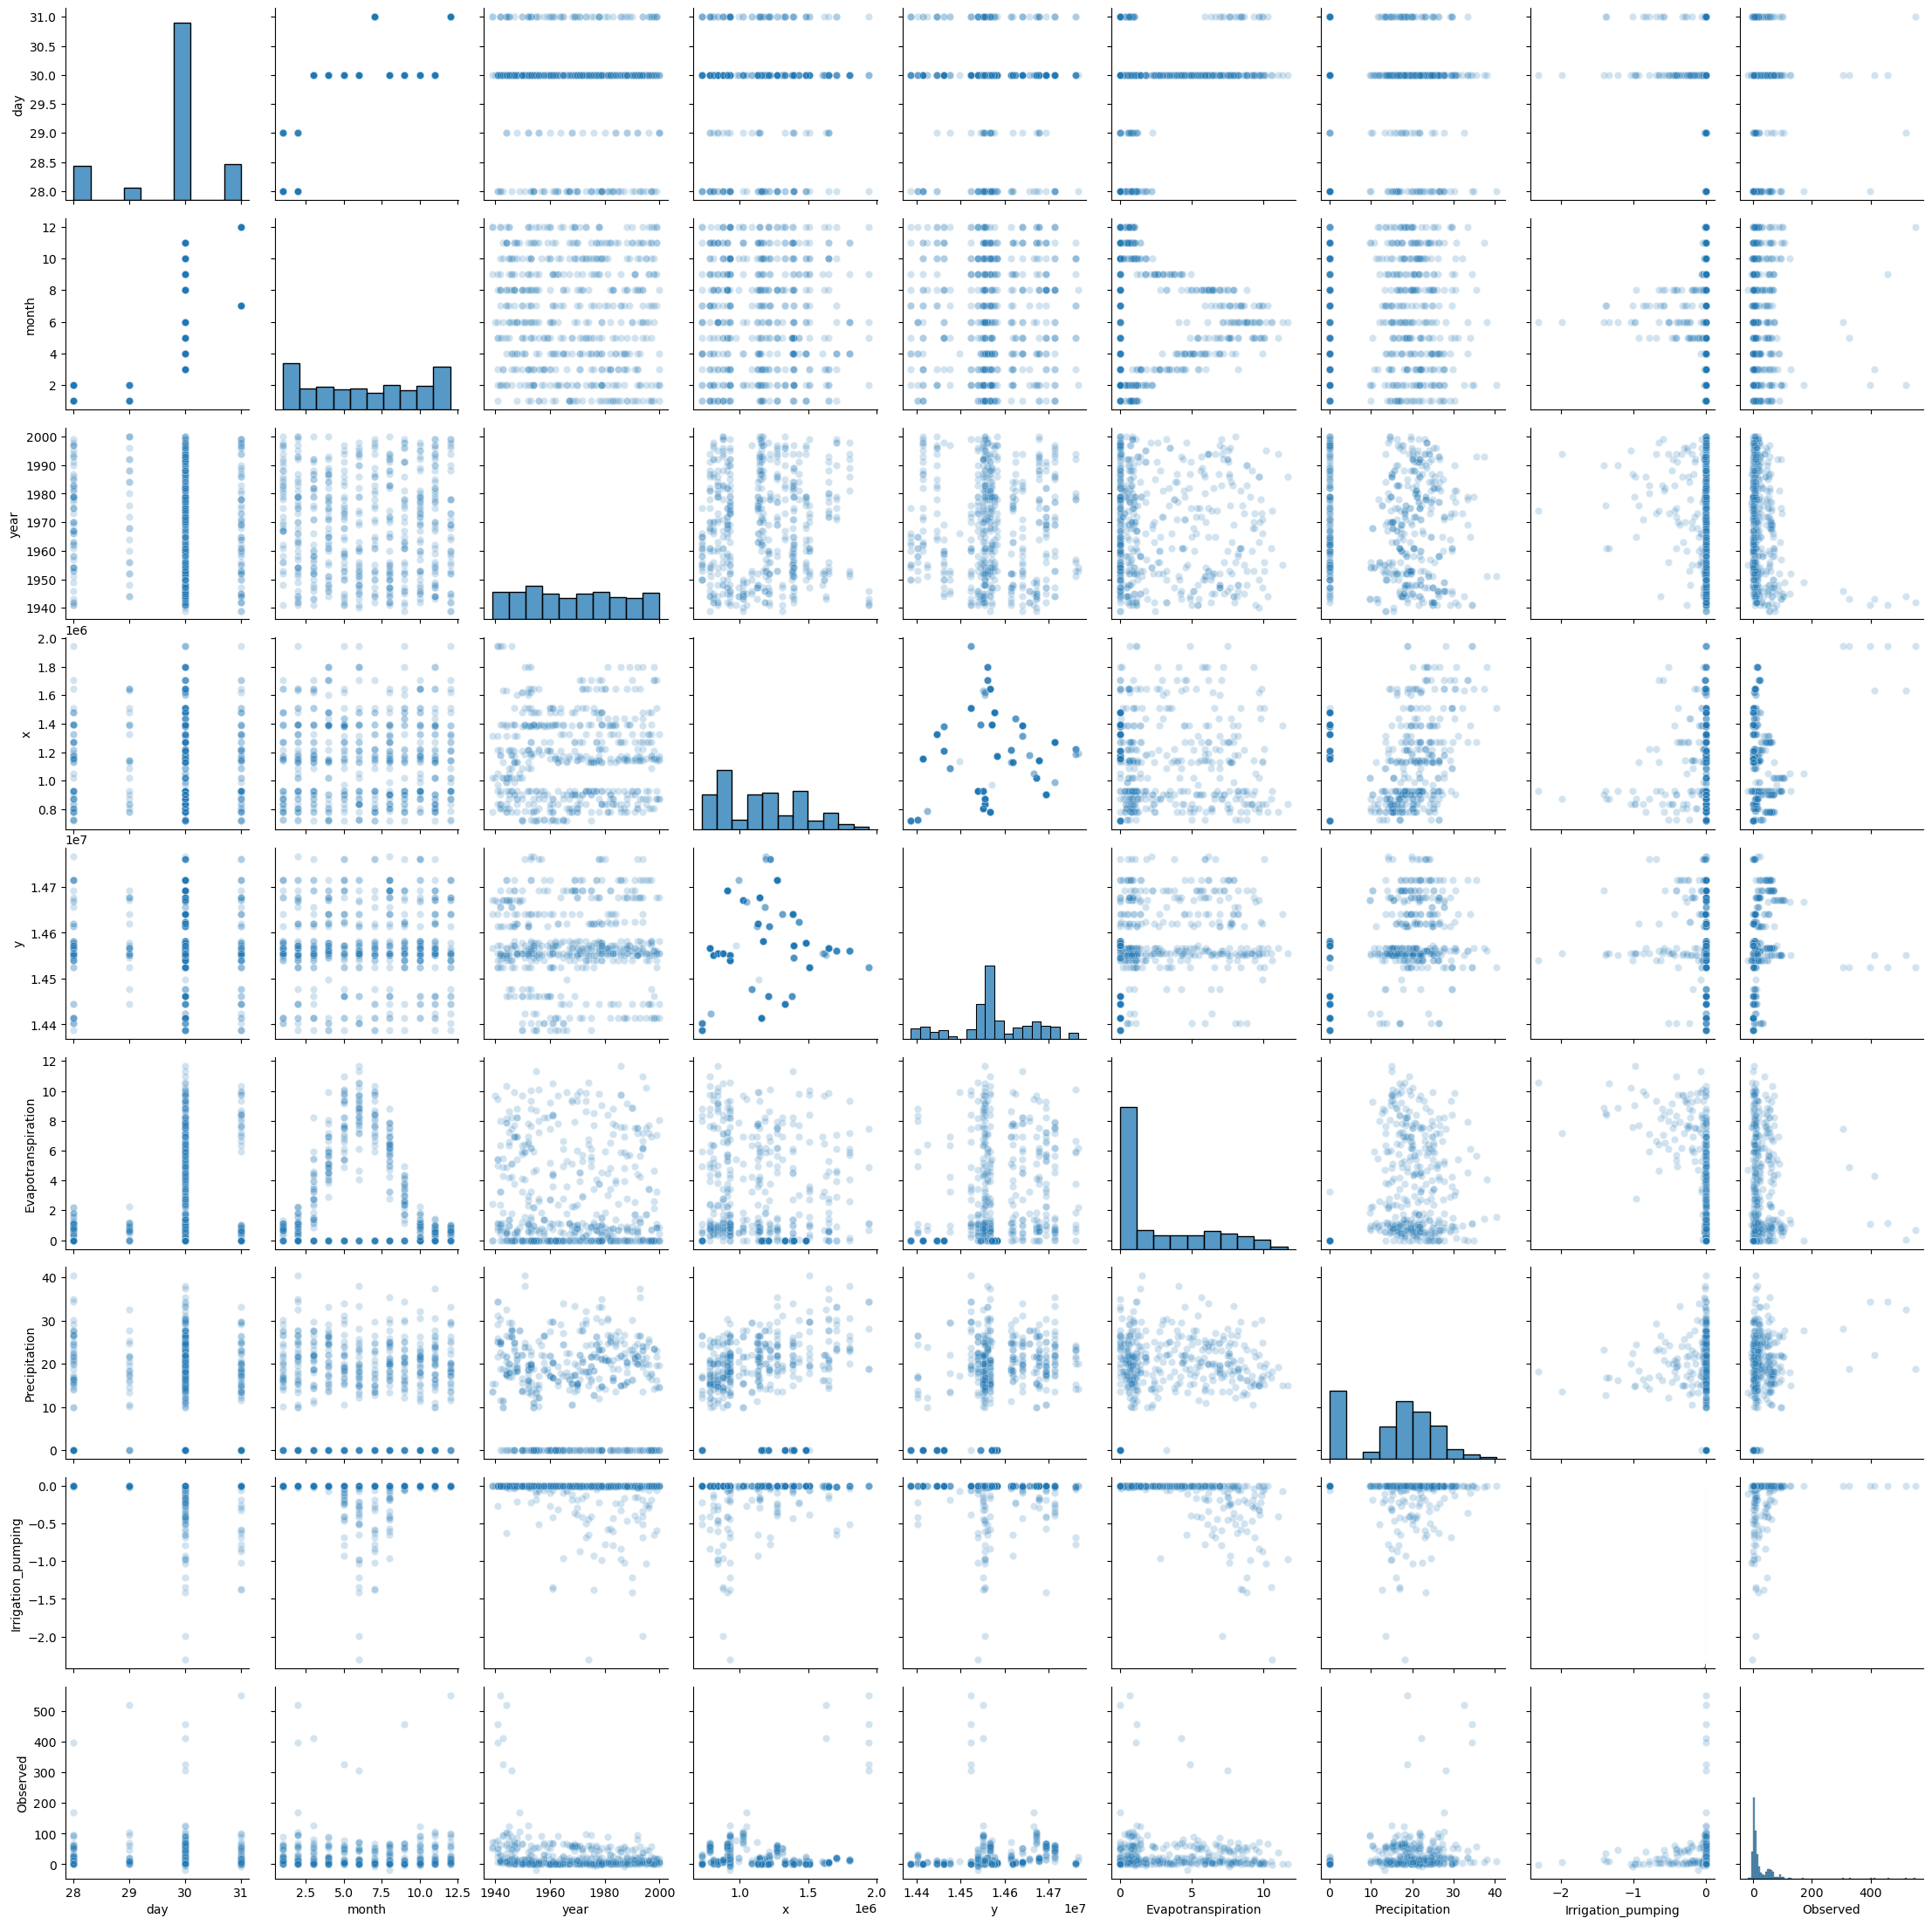

In [5]:
pairgrid = sns.PairGrid(train_sample)
pairgrid.map_diag(sns.histplot)
pairgrid.map_offdiag(sns.scatterplot, alpha = 0.2)

In [6]:
train.describe()

,day,month,year,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
count,11693.000000,11693.000000,11693.000000,1.169300e+04,1.169300e+04,11693.000000,11693.000000,11693.000000,11693.000000
mean,29.873343,6.454203,1968.689387,1.168758e+06,1.457083e+07,2.710871,14.960448,-0.091530,23.988885
std,0.835485,3.453205,17.255054,2.928869e+05,8.345995e+04,3.175613,10.470351,0.273172,56.369140
min,28.000000,1.000000,1939.000000,7.218700e+05,1.438704e+07,0.000000,0.000000,-3.164700,-22.000000
25%,30.000000,3.000000,1953.000000,9.066700e+05,1.454544e+07,0.000000,0.000000,-0.012000,2.003607
50%,30.000000,6.000000,1968.000000,1.170670e+06,1.456128e+07,1.060000,17.510000,0.000000,7.730000
75%,30.000000,9.000000,1984.000000,1.392430e+06,1.461936e+07,5.420000,22.370000,0.000000,22.750492
max,31.000000,12.000000,2000.000000,1.941550e+06,1.476720e+07,12.100000,40.380000,0.000000,739.672130


In [7]:
train.corr()

,day,month,year,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
day,1.000000,0.682150,-0.018095,0.000891,-0.008278,-0.003546,0.241034,-0.005877,-0.177629,-0.040354
month,0.682150,1.000000,-0.025964,-0.000328,-0.002757,0.002862,-0.111787,-0.004111,-0.008048,-0.039954
year,-0.018095,-0.025964,1.000000,-0.143897,0.068082,-0.014376,-0.032792,-0.023997,-0.203429,-0.232484
Segment_id,0.000891,-0.000328,-0.143897,1.000000,0.242122,0.059185,-0.047558,-0.047188,0.062578,0.340418
x,-0.008278,-0.002757,0.068082,0.242122,1.000000,0.090277,-0.165398,-0.012998,0.126536,0.096723
y,-0.003546,0.002862,-0.014376,0.059185,0.090277,1.000000,0.232643,0.421575,-0.045906,0.099291
Evapotranspiration,0.241034,-0.111787,-0.032792,-0.047558,-0.165398,0.232643,1.000000,0.428167,-0.496158,0.059620
Precipitation,-0.005877,-0.004111,-0.023997,-0.047188,-0.012998,0.421575,0.428167,1.000000,-0.156893,0.270281
Irrigation_pumping,-0.177629,-0.008048,-0.203429,0.062578,0.126536,-0.045906,-0.496158,-0.156893,1.000000,0.053735
Observed,-0.040354,-0.039954,-0.232484,0.340418,0.096723,0.099291,0.059620,0.270281,0.053735,1.000000


### Observed

<Axes: xlabel='Observed', ylabel='Count'>

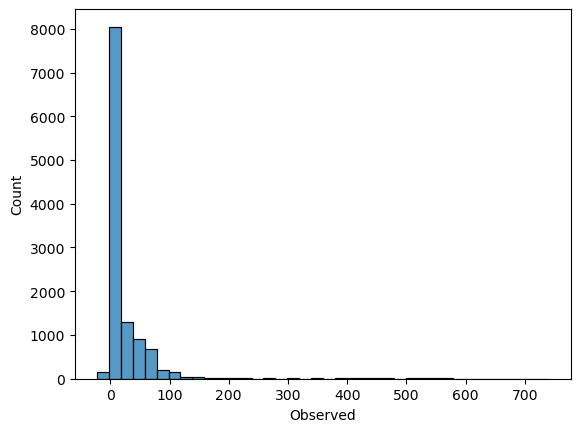

In [8]:
sns.histplot(data=train, x='Observed', binwidth=20)

<Axes: ylabel='Count'>

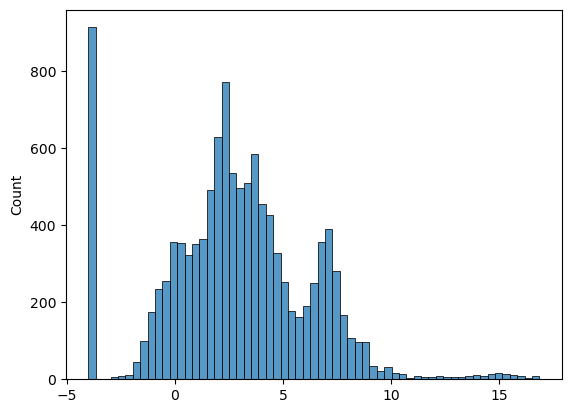

In [9]:
observed_mod = boxcox(train.Observed, 0.25)
sns.histplot(observed_mod)

### Evapotranspiration

count    11693.000000
mean         2.710871
std          3.175613
min          0.000000
25%          0.000000
50%          1.060000
75%          5.420000
max         12.100000
Name: Evapotranspiration, dtype: float64

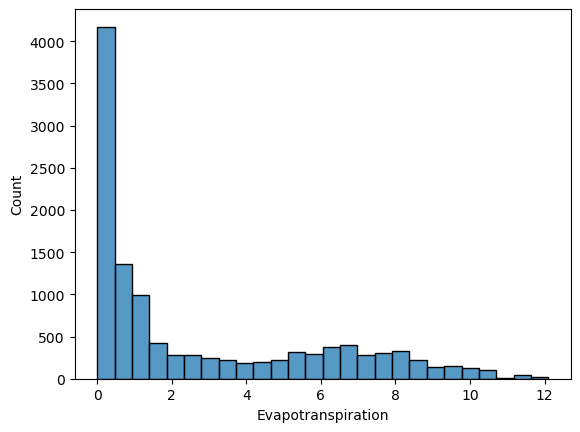

In [10]:
sns.histplot(data=train, x="Evapotranspiration")
display(train.Evapotranspiration.describe())

<Axes: ylabel='Count'>

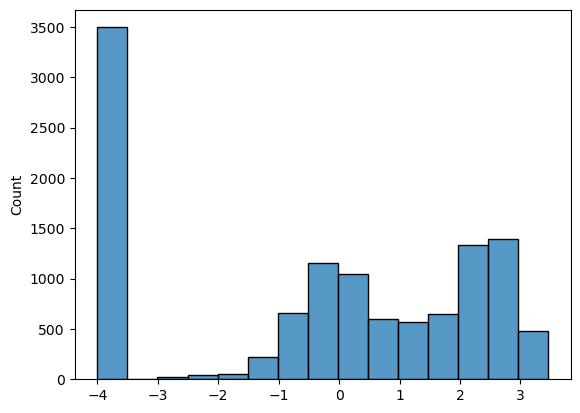

In [11]:
sns.histplot(boxcox(train.Evapotranspiration, 0.25))

<Axes: xlabel='Evapotranspiration', ylabel='Observed'>

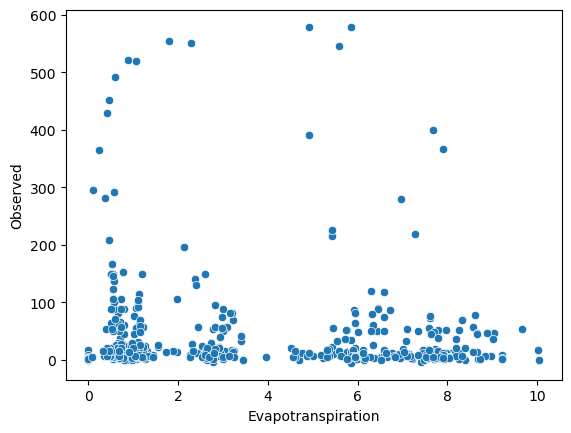

In [12]:
evapotranspiration_flow = train.groupby(['x', 'y', 'month'], as_index=False).agg({'Evapotranspiration':'median', 'Observed':'median'})
sns.scatterplot(evapotranspiration_flow, x='Evapotranspiration', y='Observed')

### Precipitation

<Axes: xlabel='Precipitation', ylabel='Count'>

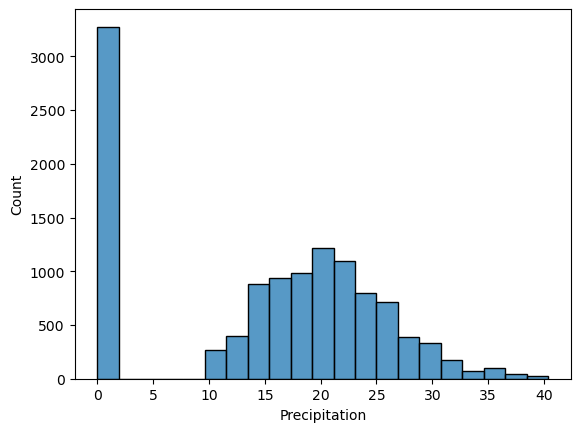

In [13]:
sns.histplot(data=train, x="Precipitation")

<Axes: xlabel='Precipitation', ylabel='Observed'>

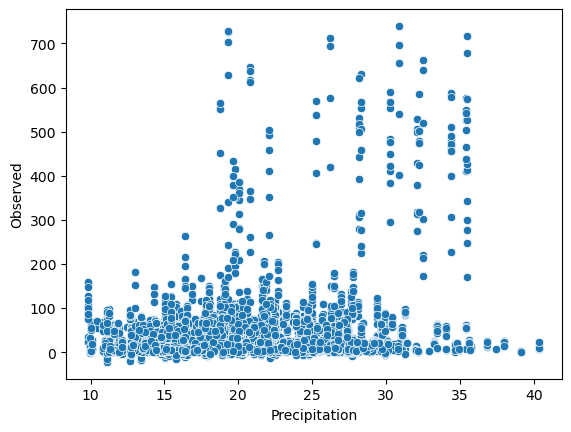

In [14]:
# scatterplot of precipitation vs observed
sns.scatterplot(data=train.loc[train.Precipitation != 0, :], x="Precipitation", y ="Observed")

<Axes: xlabel='month', ylabel='count'>

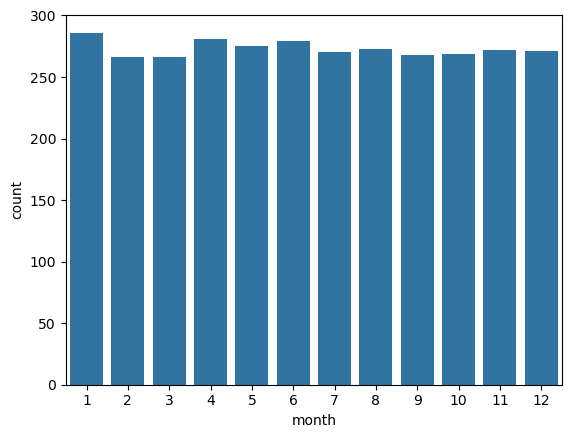

In [15]:
# months with zero precipitation
sns.countplot(data=train.loc[train.Precipitation == 0, :], x='month')

<Axes: xlabel='Precipitation', ylabel='Count'>

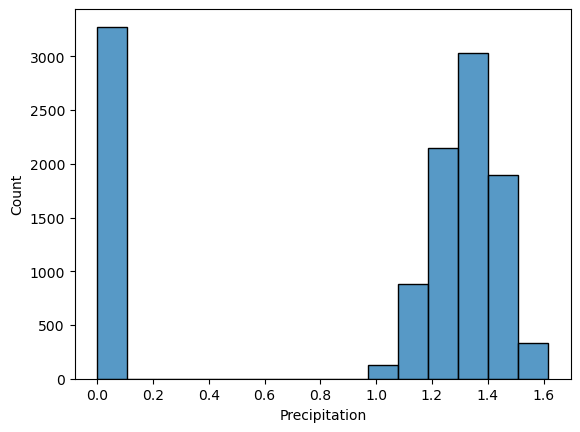

In [16]:
sns.histplot(np.log10(train.Precipitation + 1))

C:\Users\nicol\AppData\Local\Temp\ipykernel_5184\2669051297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june.Observed = boxcox(june.Observed, 0.25)


<Axes: xlabel='Precipitation', ylabel='Observed'>

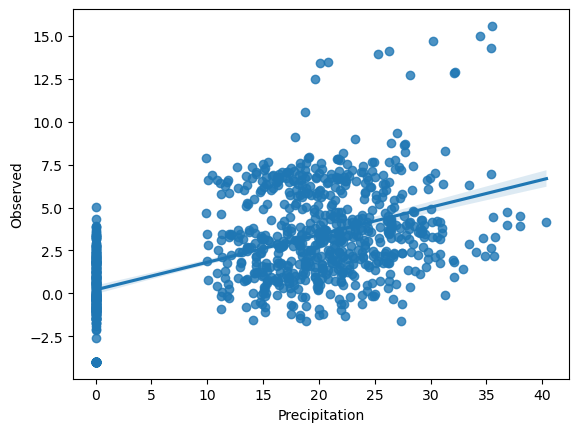

In [17]:
# precipitation_flow = train.groupby(['x', 'y', 'month', 'year'], as_index=False).agg({'Precipitation':'mean', 'Observed':'mean'})
# precipitation_flow_june = precipitation_flow.loc[precipitation_flow.month == 10, :]
# sns.scatterplot(precipitation_flow_june, x='Precipitation', y='Observed')

june = train.loc[(train.month == 6), :]
june.Observed = boxcox(june.Observed, 0.25)
sns.regplot(june, x='Precipitation', y='Observed')

In [18]:
# pairwise plot of cases where precipitation is 0
# precipitation_0 = train.loc[train.Precipitation == 0, :]
# precipitation_0.describe()
# pairgrid = sns.PairGrid(precipitation_0.sample(n=500))
# pairgrid.map_diag(sns.histplot)
# pairgrid.map_offdiag(sns.scatterplot, alpha = 0.2)

### Month

<Axes: xlabel='month', ylabel='Observed'>

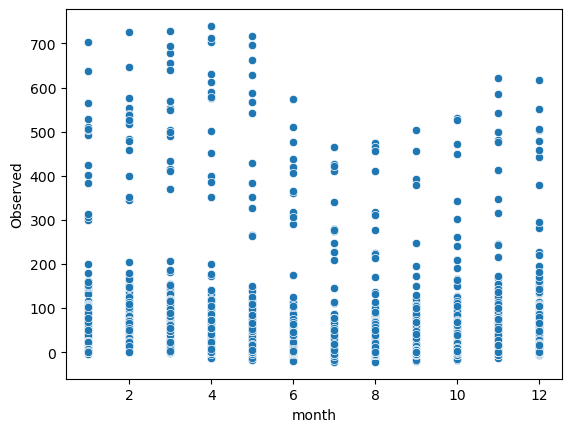

In [19]:
sns.scatterplot(data=train, x='month', y = 'Observed')

C:\Users\nicol\AppData\Local\Temp\ipykernel_5184\3256363104.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_location_observed = train.groupby(['Segment_id', 'month']).agg({'Observed':'mean'}).reset_index()


,Segment_id,month,Observed
495,256,4,581.332552
483,239,4,527.743171
447,194,4,122.704262
471,205,4,96.374317
423,188,4,87.695583


Text(0.5, 0, 'Month')

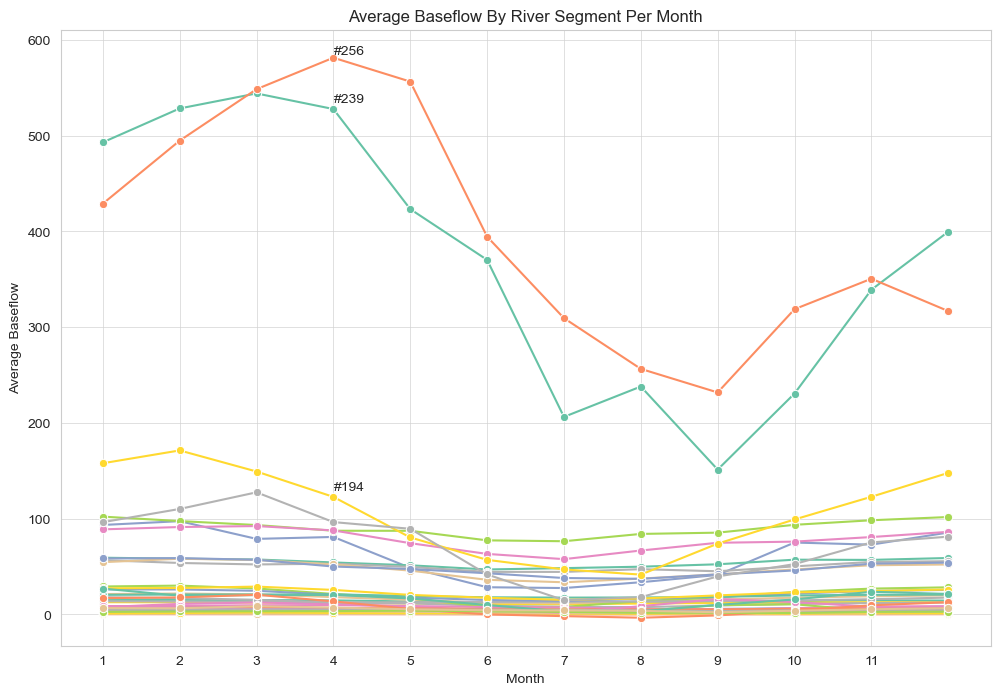

In [20]:
plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
plt.grid(True, linewidth=0.5, color='lightgray')
month_location_observed = train.groupby(['Segment_id', 'month']).agg({'Observed':'mean'}).reset_index()
display(month_location_observed.loc[month_location_observed.month == 4].sort_values(['Observed'], ascending=False).head())
month_location_observed_plot = sns.lineplot(data=month_location_observed, x='month', y='Observed', hue='Segment_id', 
             legend=False,
            palette='Set2',
            marker='o')
month_location_observed_plot.annotate("#256", (4, 585))
month_location_observed_plot.annotate("#239", (4, 535))
month_location_observed_plot.annotate("#194", (4, 130))
plt.xticks(ticks=range(1, 12))
plt.title('Average Baseflow By River Segment Per Month')
plt.ylabel('Average Baseflow')
plt.xlabel('Month')

### Geographic Information

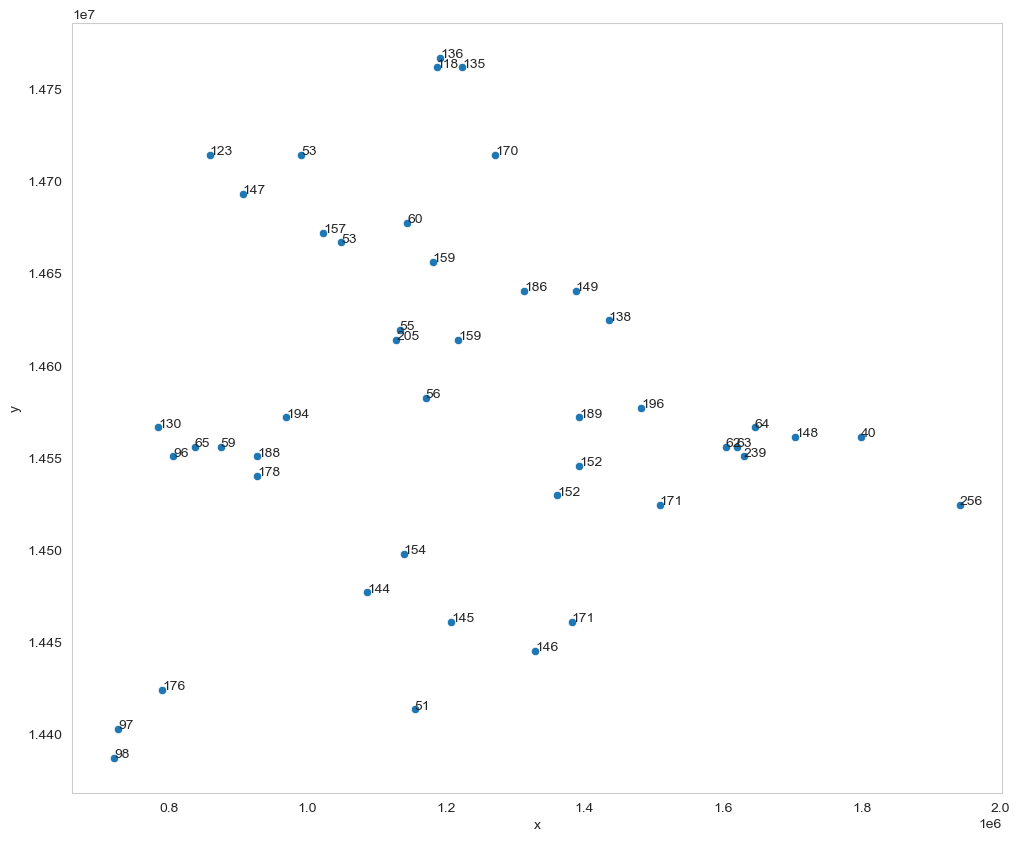

In [21]:
plt.figure(figsize=(12, 10))
plt.grid(False)
location_count = train.value_counts(['Segment_id', 'x', 'y']).sort_index().reset_index()
location_count_map = sns.scatterplot(data=location_count, x="x", y="y")

for i, label in enumerate(location_count.Segment_id):
    location_count_map.annotate(label, (location_count.loc[i, 'x'], location_count.loc[i, 'y']))

C:\Users\nicol\AppData\Local\Temp\ipykernel_5184\337497758.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  location_flow = train.dropna(subset='Observed').groupby(['Segment_id', 'x', 'y']).agg({'Observed':'mean'}).reset_index()


,Segment_id,x,y,Observed
57265,256,1941550,14524320,396.110811
55781,239,1630030,14550720,366.048704
3155,53,1049230,14666880,106.098830
50794,194,970030,14571840,105.827170
38589,157,1022830,14672160,90.489154


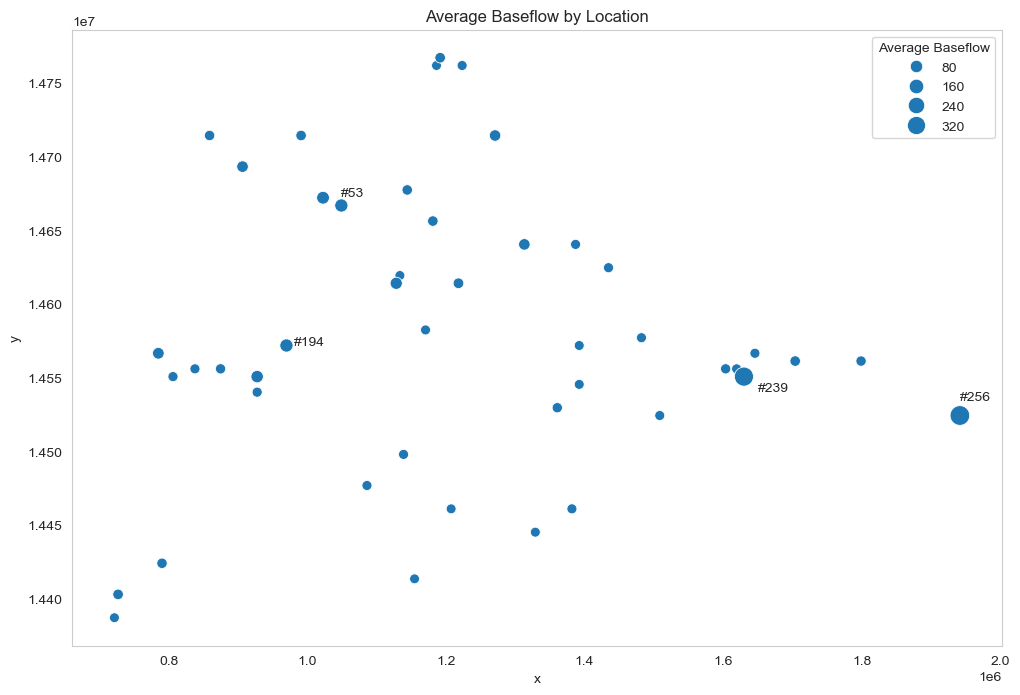

In [22]:
plt.figure(figsize=(12, 8))
plt.grid(False)
location_flow = train.dropna(subset='Observed').groupby(['Segment_id', 'x', 'y']).agg({'Observed':'mean'}).reset_index()
display(location_flow.sort_values('Observed', ascending=False).head(5))
location_flow_map = sns.scatterplot(data=location_flow, x="x", y="y", size="Observed", sizes=(50, 200))

location_flow_map.annotate("#256", (1941550, 14534320))
location_flow_map.annotate("#239", (1650030, 14540720))
location_flow_map.annotate("#53", (1049230, 14672880))
location_flow_map.annotate("#194", (980030, 14571840))

plt.title("Average Baseflow by Location")
plt.legend(title="Average Baseflow")

## Data Pre-processing

In [23]:
train_mod = train.copy()

# create a summer feature
train_mod['Summer'] = np.where((train_mod.month >= 6) & (train_mod.month <= 10), 1, 0)


# one hot encode the months
month_encoder = OneHotEncoder(sparse_output=False)
months_onehot = month_encoder.fit_transform(train_mod.loc[:, ['month']])
train_mod[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] = months_onehot

# one hot encode the segment ids
segment_encoder = OneHotEncoder(sparse_output=False)
segments_onehot = segment_encoder.fit_transform(train_mod.loc[:, ['Segment_id']])
train_mod[segment_encoder.get_feature_names_out()] = segments_onehot

In [24]:
# drop unnecessary columns 
train_mod = train_mod.drop(columns=['day', 'month', 'Segment_id']).dropna()
X_train = train_mod.drop(columns='Observed')
y_train = train_mod.loc[:, 'Observed']

In [25]:
# train_mod.head(30)
train_mod.columns
all_pred_columns = "+".join(train_mod.columns.difference(["Observed"]))
ols_formula = "Observed ~ " + all_pred_columns
ols_formula

'Observed ~ Evapotranspiration+Irrigation_pumping+Precipitation+Segment_id_118+Segment_id_123+Segment_id_130+Segment_id_135+Segment_id_136+Segment_id_138+Segment_id_144+Segment_id_145+Segment_id_146+Segment_id_147+Segment_id_148+Segment_id_149+Segment_id_152+Segment_id_154+Segment_id_157+Segment_id_159+Segment_id_170+Segment_id_171+Segment_id_176+Segment_id_178+Segment_id_186+Segment_id_188+Segment_id_189+Segment_id_194+Segment_id_196+Segment_id_205+Segment_id_239+Segment_id_256+Segment_id_40+Segment_id_51+Segment_id_53+Segment_id_55+Segment_id_56+Segment_id_59+Segment_id_60+Segment_id_62+Segment_id_63+Segment_id_64+Segment_id_65+Segment_id_96+Segment_id_97+Segment_id_98+Summer+apr+aug+dec+feb+jan+jul+jun+mar+may+nov+oct+sep+x+y+year'

## Initial Linear Model from Stats Model

In [26]:
lm = smf.ols(formula=ols_formula, data=train_mod).fit()

In [27]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     890.5
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:16:26   Log-Likelihood:                -53834.
No. Observations:               11693   AIC:                         1.078e+05
Df Residuals:                   11634   BIC:                         1.082e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9403.8089    485.581     19.366      0.000    8451.989    1.04e+04
Evapotranspiration    -1.0984      0.139     -7.889      0.000      -1.371      -0.825
Irrigation_pumping    -0.3065      1.107     -0.277      0.782      -2.476       1.862
Precipitation          0.5967      0.047     12.615      0.000       0.504       0.689
Segment_id_118       327.7479     19.258     17.019      0.000     290.000     365.496
Segment_id_123       411.0037     23.644     17.383      0.000     364.658     457.349
Segment_id_130       369.4866     18.002     20.524      0.000     334.199     404.774
Segment_id_135       321.9915     18.588     17.322      0.000     285.555     358.428
Segment_id_136       350.7865     19.318     18.159      0.000     312.921     388.652
Segment_id_138       152.3137     11.448     13.305      0.000     129.874     174.753
Segment_id_144       151.6527      9.560     15.863      0.000     132.913     170.392
Segment_id_145       104.6397      7.312     14.310      0.000      90.307     118.973
Segment_id_146        56.6463      5.990      9.457      0.000      44.906      68.387
Segment_id_147       419.1363     20.532     20.414      0.000     378.891     459.382
Segment_id_148        25.2605     10.420      2.424      0.015       4.836      45.685
Segment_id_149       177.1773     12.248     14.465      0.000     153.168     201.186
Segment_id_152       108.3915      9.033     11.999      0.000      90.685     126.098
Segment_id_154       149.7071      9.994     14.980      0.000     130.118     169.297
Segment_id_157       402.3002     17.933     22.433      0.000     367.148     437.453
Segment_id_159       238.7598     13.430     17.778      0.000     212.434     265.085
Segment_id_170       312.1641     16.138     19.343      0.000     280.531     343.798
Segment_id_171        49.3822      7.525      6.562      0.000      34.632      64.133
Segment_id_176       220.5567     13.138     16.787      0.000     194.803     246.310
Segment_id_178       254.8017     14.402     17.692      0.000     226.572     283.032
Segment_id_186       239.7983     13.016     18.424      0.000     214.285     265.312
Segment_id_188       332.8910     14.798     22.495      0.000     303.884     361.898
Segment_id_189       129.1760     10.059     12.842      0.000     109.459     148.893
Segment_id_194       359.4334     15.190     23.663      0.000     329.659     389.208
Segment_id_196       106.9767     10.065     10.628      0.000      87.247     126.706
Segment_id_205       302.4136     14.163     21.352      0.000     274.652     330.176
Segment_id_239       384.1006      9.781     39.270      0.000     364.928     403.273
Segment_id_256       291.3215     13.849     21.035      0.000     264.174     318.469
Segment_id_40        -11.2607     11.6

## Revised Linear Model from Stats Model

In [28]:
train_mod2 = train.copy()

# create a summer feature
train_mod2['Summer'] = np.where((train_mod2.month >= 6) & (train_mod2.month <= 10), 1, 0)


# one hot encode the months
month_encoder = OneHotEncoder(sparse_output=False)
months_onehot = month_encoder.fit_transform(train_mod2.loc[:, ['month']])
train_mod2[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] = months_onehot

# one hot encode the segment ids
segment_encoder = OneHotEncoder(sparse_output=False)
segments_onehot = segment_encoder.fit_transform(train_mod2.loc[:, ['Segment_id']])
train_mod2[segment_encoder.get_feature_names_out()] = segments_onehot


# transform Y
train_mod2['Observed'] = boxcox(train_mod2.Observed, 0.5)

# # transform Irrigation pumping
# train_mod2['Irrigation_pumping'] = boxcox(train_mod2.Irrigation_pumping, 0.25)

# # transform Evapotranspiration
# train_mod2['Evapotranspiration'] = np.log10(train_mod2.Evapotranspiration + 1)

# # transform Precipitation 
# train_mod2['Precipitation'] = np.log10(train_mod2.Precipitation + 1)

# drop non-significant columns 
train_mod2 = train_mod2.drop(columns=['day', 'month', 'Segment_id', 'Summer', 'Irrigation_pumping', 'Segment_id_40']).dropna()
X_train = train_mod2.drop(columns='Observed')
y_train = train_mod2.loc[:, 'Observed']

# train_mod.head(30)
train_mod2.columns
all_pred_columns = "+".join(train_mod2.columns.difference(["Observed"]))
ols_formula = "Observed ~ " + all_pred_columns
ols_formula

lm = smf.ols(formula=ols_formula, data=train_mod2).fit()

In [29]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1612.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:16:27   Log-Likelihood:                -25445.
No. Observations:               11520   AIC:                         5.101e+04
Df Residuals:                   11462   BIC:                         5.143e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1343.7847     46.393     28.965      0.000    1252.846    1434.724
Evapotranspiration    -0.1621      0.012    -13.193      0.000      -0.186      -0.138
Precipitation          0.0805      0.004     18.525      0.000       0.072       0.089
Segment_id_118        40.8527      1.785     22.890      0.000      37.354      44.351
Segment_id_123        56.1794      2.393     23.477      0.000      51.489      60.870
Segment_id_130        52.1005      2.063     25.253      0.000      48.056      56.145
Segment_id_135        42.9046      1.697     25.279      0.000      39.578      46.231
Segment_id_136        49.0365      1.783     27.503      0.000      45.542      52.531
Segment_id_138        20.5777      0.912     22.557      0.000      18.789      22.366
Segment_id_144        19.1127      1.313     14.553      0.000      16.538      21.687
Segment_id_145        10.4305      1.021     10.219      0.000       8.430      12.431
Segment_id_146         5.0146      0.779      6.437      0.000       3.487       6.542
Segment_id_147        58.8244      2.118     27.771      0.000      54.672      62.976
Segment_id_148         5.4596      0.269     20.322      0.000       4.933       5.986
Segment_id_149        23.5728      1.039     22.691      0.000      21.536      25.609
Segment_id_152        12.5772      0.801     15.696      0.000      11.007      14.148
Segment_id_154        19.2458      1.273     15.118      0.000      16.750      21.741
Segment_id_157        56.2100      1.843     30.497      0.000      52.597      59.823
Segment_id_159        33.8452      1.355     24.986      0.000      31.190      36.500
Segment_id_170        44.9687      1.466     30.677      0.000      42.095      47.842
Segment_id_171         5.3686      0.591      9.089      0.000       4.211       6.526
Segment_id_176        29.6384      1.813     16.345      0.000      26.084      33.193
Segment_id_178        34.8968      1.725     20.227      0.000      31.515      38.279
Segment_id_186        35.1087      1.201     29.241      0.000      32.755      37.462
Segment_id_188        46.9196      1.746     26.880      0.000      43.498      50.341
Segment_id_189        15.1248      0.849     17.821      0.000      13.461      16.788
Segment_id_194        48.9379      1.730     28.291      0.000      45.547      52.329
Segment_id_196        12.5592      0.688     18.249      0.000      11.210      13.908
Segment_id_205        42.2293      1.496     28.221      0.000      39.296      45.162
Segment_id_239        34.9349      0.429     81.340      0.000      34.093      35.777
Segment_id_256        20.1985      0.469     43.083      0.000      19.280      21.117
Segment_id_51          7.2130      1.070      6.740      0.000       5.115       9.311
Segment_id_53         53.5257      1.8

## Inspect Residuals

In [30]:
train_pred = lm.predict(X_train)
train_resid = train_pred - y_train
residuals = pd.DataFrame({'actual':y_train, 'predicted':train_pred, 'residual':train_resid})
residuals = pd.concat([residuals, X_train], axis = 1)

<Axes: xlabel='predicted', ylabel='residual'>

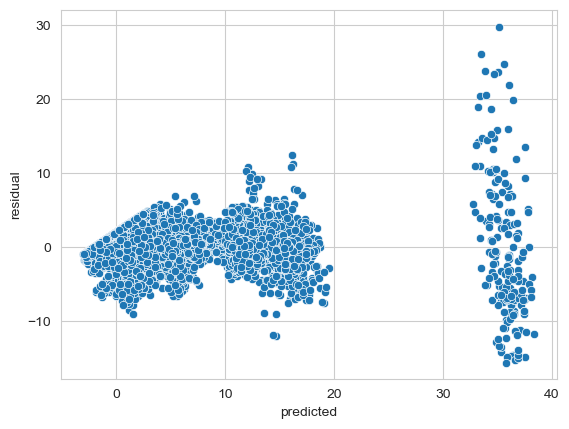

In [31]:
sns.scatterplot(data=residuals, x ='predicted', y ='residual')

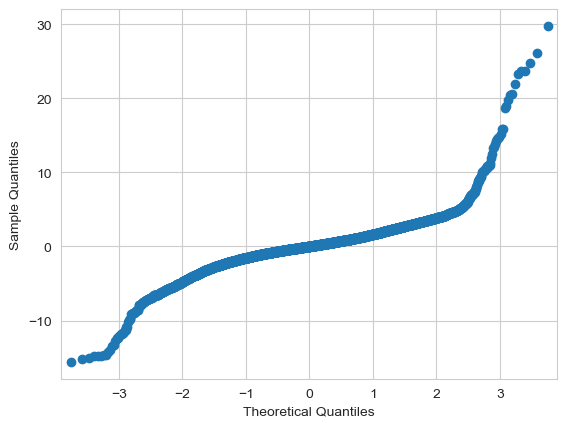

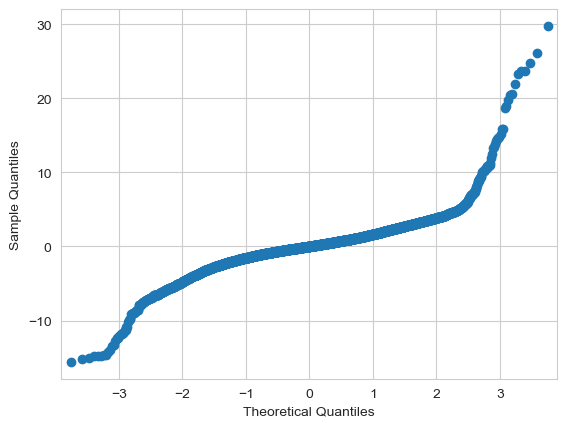

In [32]:
qqplot(residuals.residual)
# ref_line = [0, 50]
# plt.plot(ref_line, ref_line)

<Axes: xlabel='actual', ylabel='predicted'>

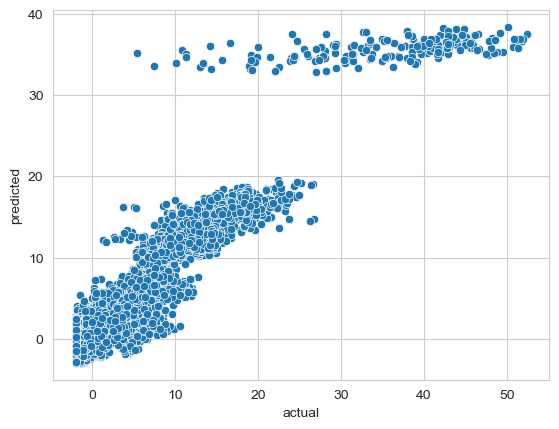

In [33]:
sns.scatterplot(data=residuals, x='actual', y='predicted')


<Axes: xlabel='Precipitation', ylabel='residual'>

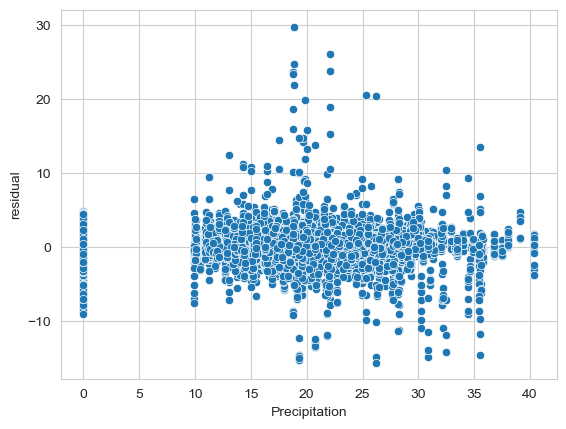

In [34]:
sns.scatterplot(data=residuals, x='Precipitation', y='residual')

<Axes: xlabel='Evapotranspiration', ylabel='residual'>

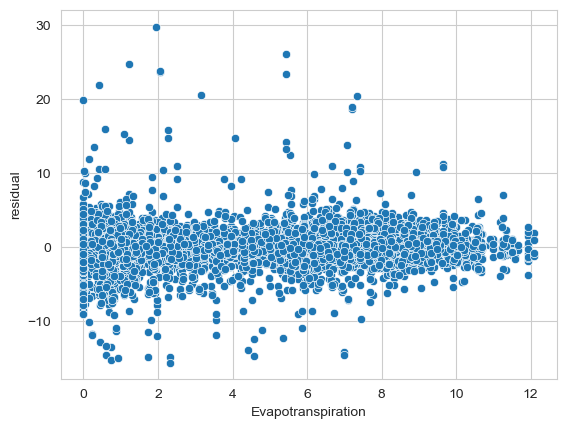

In [35]:
sns.scatterplot(data=residuals, x='Evapotranspiration', y='residual')

<Axes: xlabel='x', ylabel='residual'>

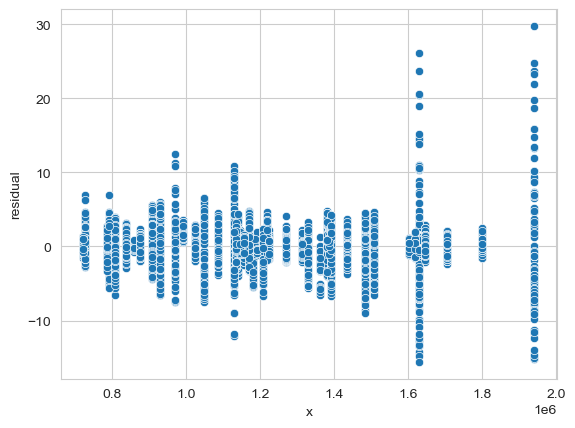

In [36]:
sns.scatterplot(data=residuals, x='x', y='residual')

<Axes: xlabel='y', ylabel='residual'>

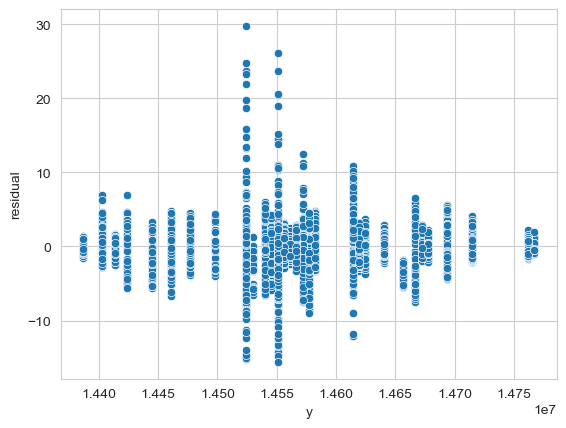

In [37]:
sns.scatterplot(data=residuals, x='y', y='residual')

## Linear Model from Sklearn

In [38]:
sklm = LinearRegression()
sklm.fit(X_train, y_train)
sklm_results = pd.DataFrame({'feature':X_train.columns, 'coeff': sklm.coef_})
sklm_r2 = sklm.score(X_train, y_train)
sklm_r2_adj = 1 - (1-sklm_r2) * (len(y_train)-1)/(len(y_train)-X.shape[1]-1)
print("R^2:", sklm_r2)
print("R^2 Adj:", sklm_r2_adj)
sklm_results

R^2: 0.8890728698714243
R^2 Adj: 0.8889861327583786


,feature,coeff
0,year,-0.022156
1,x,0.000043
2,y,-0.000102
3,Evapotranspiration,-0.162090
4,Precipitation,0.080485
5,jan,0.336837
6,feb,0.555677
7,mar,0.872454
8,apr,0.850629
9,may,0.510773


Text(0, 0.5, 'Month')

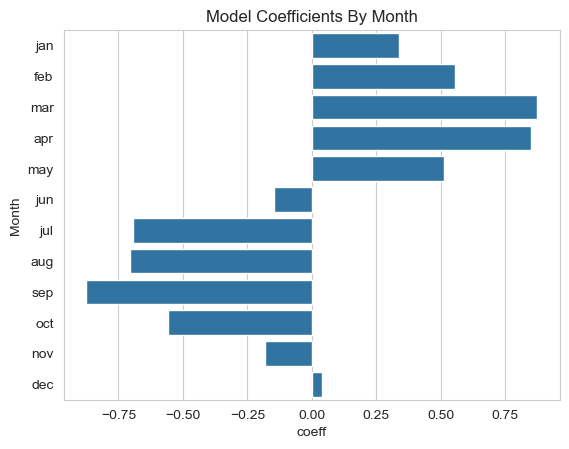

In [39]:
sns.barplot(sklm_results.iloc[[5,6,7,8,9,10,11,12,13,14,15,16],:], x='coeff', y='feature')
plt.title("Model Coefficients By Month")
plt.ylabel("Month")

Text(0, 0.5, '')

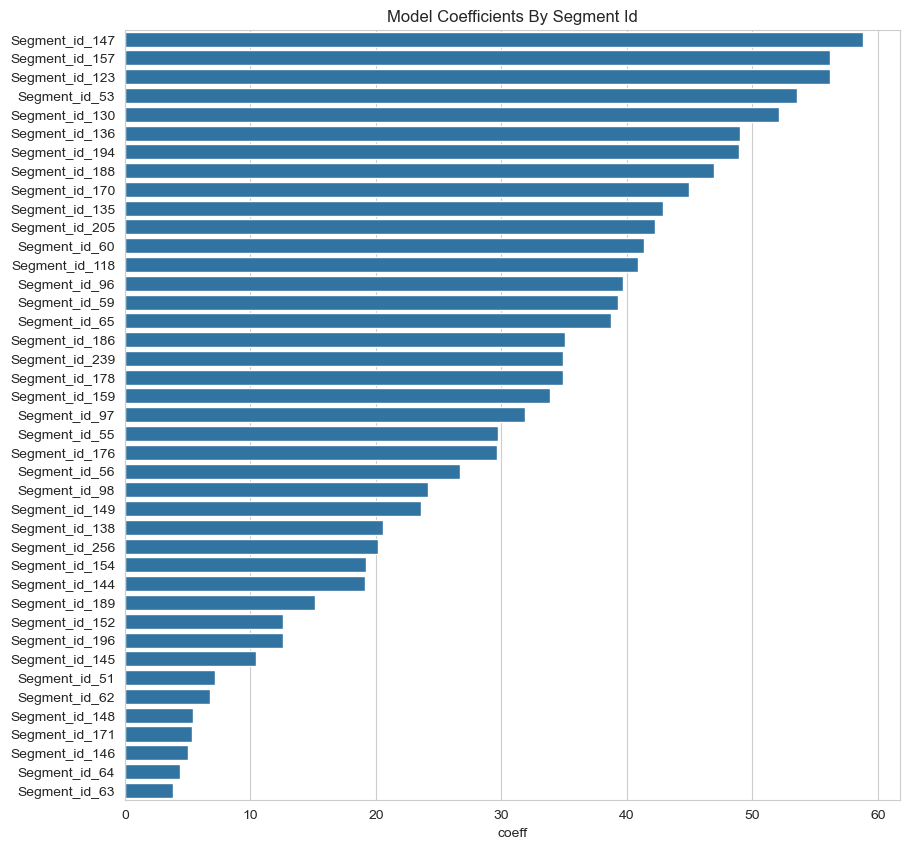

In [40]:
plt.figure(figsize=(10,10))
segment_coeff = sklm_results.iloc[range(17, 58),:]
sorted_order = segment_coeff.sort_values('coeff', ascending=False)['feature'].tolist()
sns.barplot(segment_coeff, x='coeff', y='feature', order=sorted_order)
plt.title("Model Coefficients By Segment Id")
plt.ylabel("")

It appears that the highest coefficients match with locations that are near the sources, while the ares with lower coefficients tend to be more downstream. Baseflow happens more 

Model interpretations:
Baseflow decreases with increasing Evapotranspiration. -0.1621
Baseflow increases with increasing Precipitation. 0.0805
Baseflow is dependent on geographic location
* Baseflow increases more dramatically in segments of the river system that are closer to the water source, and increases less dramatically in locations more downstream.
* Baseflow increases the more east (or downstream) in the river system, while it decreases going north. 
Baseflow is dependent on the time of year
* Baseflow increases from December to May and decreases from Jun to November

## Model Evaluation on Test Set

In [41]:
# one hot encode the months
test_mod = test.copy()

test_months = month_encoder.transform(test_mod.loc[:, ['month']])
test_mod[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] = test_months

# one hot encode the segment ids
test_segments = segment_encoder.transform(test.loc[:, ['Segment_id']])
test_mod[segment_encoder.get_feature_names_out()] = test_segments

# transform Y
test_mod['Observed'] = boxcox(test_mod.Observed, 0.5)

test_mod = test_mod.drop(columns=['day', 'month', 'Segment_id', 'Irrigation_pumping', 'Segment_id_40']).dropna()

# test_mod = test_mod.reindex(columns=X_train.columns, fill_value=0)

X_test = test_mod.drop(columns='Observed')
y_test = test_mod.loc[:, 'Observed']

In [42]:
test_r2 = sklm.score(X_test, y_test)
test_r2_adj = 1 - (1-test_r2) * (len(y_test)-1)/(len(y_test)-X.shape[1]-1)
print("R^2:", test_r2)
print("R^2 Adj:", test_r2_adj)

R^2: 0.8907167346369498
R^2 Adj: 0.8904598661626046
